## Can we group students based on the number of upper division (updv.num) courses they’ve taken and their comfortability in math, stats, and programming? 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

In [21]:
current_path = Path().resolve()

In [22]:
ROOT = current_path.parents[0]

In [23]:
df = pd.read_csv(f'{ROOT}/data/background-clean.csv')


print(f"Dataset shape: {df.shape}")
print(f"Number of students: {df.shape[0]}")

Dataset shape: (51, 30)
Number of students: 51


In [24]:
# Convert updv.num from categorical to numerical (sort of roughly estimating the number of courses)
# Convert categorical course numbers to numeric scale
updv_mapping = {
    '0-2': 1,    
    '3-5': 4,      
    '6-8': 7,    
    '9+': 10     
}

df['updv_numeric'] = df['updv.num'].map(updv_mapping)

feature_names = ['updv_numeric', 'prog.comf', 'math.comf', 'stat.comf']
feature_labels = ['Upper Div Courses', 'Programming Comfort', 'Math Comfort', 'Statistics Comfort']

# Create clustering dataset
X = df[feature_names].copy()

In [31]:
# missing values? No
print(f"\nMissing values per feature:")
print(X.isnull().sum())


Missing values per feature:
updv_numeric    0
prog.comf       0
math.comf       0
stat.comf       0
dtype: int64


## Exploratory Data Analysis

In [32]:
print("\nSummary Statistics:")
print(X.describe())


Summary Statistics:
       updv_numeric  prog.comf  math.comf  stat.comf
count     51.000000  51.000000  51.000000  51.000000
mean       7.882353   3.862745   4.039216   4.039216
std        2.635504   0.748855   0.773583   0.799019
min        1.000000   2.000000   3.000000   2.000000
25%        7.000000   3.000000   3.000000   3.500000
50%       10.000000   4.000000   4.000000   4.000000
75%       10.000000   4.000000   5.000000   5.000000
max       10.000000   5.000000   5.000000   5.000000


We can see that the mean number of upper division courses taken is 7.88 which roughly falls under the 6-8 courses original category. Additionally, more students are comforable with math and stats rather than programming.

In [33]:
# Show distribution of course categories
print("\nCourse Distribution:")
course_dist = df['updv.num'].value_counts().sort_index()
for cat, count in course_dist.items():
    print(f"  {cat}: {count} students ({count/len(df)*100:.1f}%)")



Course Distribution:
  0-2: 2 students (3.9%)
  3-5: 8 students (15.7%)
  6-8: 14 students (27.5%)
  9+: 27 students (52.9%)


In [34]:
# Calculate correlations
print("\nFeature Correlations:")
corr_matrix = X.corr()
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        corr_val = corr_matrix.iloc[i, j]
        feat1 = feature_labels[i]
        feat2 = feature_labels[j]
        print(f"  {feat1} \u2194 {feat2}: {corr_val:.3f}")



Feature Correlations:
  Upper Div Courses ↔ Programming Comfort: 0.154
  Upper Div Courses ↔ Math Comfort: 0.277
  Upper Div Courses ↔ Statistics Comfort: 0.382
  Programming Comfort ↔ Math Comfort: 0.217
  Programming Comfort ↔ Statistics Comfort: 0.243
  Math Comfort ↔ Statistics Comfort: 0.580


Correlations range from -1 to +1, where correlations closer to -1 represent a stronger negative relationship and vice versa. 

Based on the correlations, we see weak relationships between the number of upper division courses taken and comfortability in the 3 subjects, with the highest correlation being 0.382, still relatively low, but indicating the most relationship between more upper division courses and comfortability with statistics. The strongest correlation is between math comfort and statistics comfort.

## K-means clustering

In [25]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

print(f"Before scaling, course numbers range: {X['updv_numeric'].min():.0f} to {X['updv_numeric'].max():.0f} and comfort levels range: {X[['prog.comf', 'math.comf', 'stat.comf']].min().min():.0f} to {X[['prog.comf', 'math.comf', 'stat.comf']].max().max():.0f}.")
print(f"After scaling (mean=0, std=1): all features now range approx: {X_scaled.min():.1f} to {X_scaled.max():.1f}.")
print("So, all features now have equal weight in clustering since their continuous values don't vary higher than others'.")

Before scaling, course numbers range: 1 to 10 and comfort levels range: 2 to 5.
After scaling (mean=0, std=1): all features now range approx: -2.6 to 1.5.
So, all features now have equal weight in clustering since their continuous values don't vary higher than others'.


  k=2: Inertia=134.2
  k=3: Inertia=107.4
  k=4: Inertia=86.0
  k=5: Inertia=72.4
  k=6: Inertia=63.0
  k=7: Inertia=56.7
  k=8: Inertia=47.0
  k=9: Inertia=43.0
  k=10: Inertia=38.3


  k=2: ~26 students per cluster
  k=3: ~17 students per cluster
  k=4: ~13 students per cluster
  k=5: ~10 students per cluster
  k=6: ~8 students per cluster
  k=7: ~7 students per cluster
  k=8: ~6 students per cluster
  k=9: ~6 students per cluster
  k=10: ~5 students per cluster


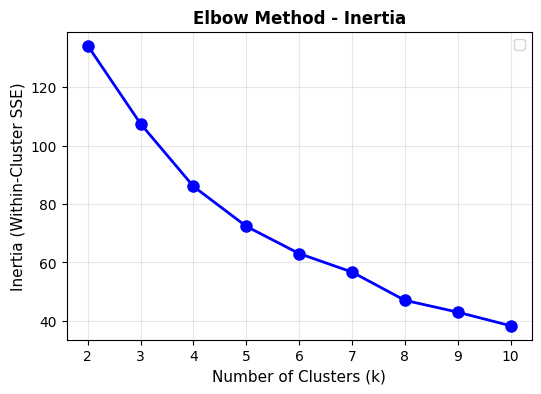

In [26]:
# Elbow method to choose k for k-means
# Range of k values to test
K = range(2, 11)

inertias = []

for k in K:
    # Fit k-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Calculate inertia (within-cluster sum of squares)
    inertias.append(kmeans.inertia_)
    
    print(f"  k={k}: Inertia={kmeans.inertia_:.1f}")
print(f"\n")

# Elbow method plotted
 
# Elbow Plot (Inertia) - use to find the elbow (point where after, intertia starts flattening out)
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(K, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=11)
ax1.set_ylabel('Inertia (Within-Cluster SSE)', fontsize=11)
ax1.set_title('Elbow Method - Inertia', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    avg_per_cluster = 51 / k # take avg
    print(f"  k={k}: ~{avg_per_cluster:.0f} students per cluster")

Based on the albow method, looking at the SSE's at each k value, intertia starts to decrease slower after $k = 5$. The plot kind of shows this as well, showing that most of the SSE decrease happens up to the 5th cluster ($k=5$).

So, we'll go ahead with $k=5$ clusters.

In [27]:
# set seed for reproducibility
np.random.seed(42)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels
X['cluster'] = cluster_labels

# Calculate clustering quality metrics
inertia = kmeans.inertia_
silhouette = silhouette_score(X_scaled, cluster_labels)

print(f"Clustering Results:")
print(f"Number of clusters: {k}")
print(f"Inertia (within-cluster SSE): {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.3f}") # evaluates how well separated clusters are from each other (-1/1 indicate very good separation)

# Show cluster sizes
print(f"\nCluster Sizes:")
cluster_sizes = df['cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} students")

Clustering Results:
Number of clusters: 5
Inertia (within-cluster SSE): 72.36
Silhouette Score: 0.293

Cluster Sizes:
Cluster 0: 11 students
Cluster 1: 9 students
Cluster 2: 13 students
Cluster 3: 8 students
Cluster 4: 10 students


In [28]:
# Calculate cluster centers in original scale
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=feature_names
)

# Calculate detailed statistics for each cluster
for cluster_id in range(k):
    cluster_data = X[X['cluster'] == cluster_id]
    cluster_df = df[df['cluster'] == cluster_id]
    
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} students")
    
    # Center values (from k-means)
    print("\n Cluster Center:")
    print(f"  Upper Div Courses: {cluster_centers.loc[cluster_id, 'updv_numeric']:.1f}")
    print(f"  Programming Comfort: {cluster_centers.loc[cluster_id, 'prog.comf']:.2f}")
    print(f"  Math Comfort: {cluster_centers.loc[cluster_id, 'math.comf']:.2f}")
    print(f"  Statistics Comfort: {cluster_centers.loc[cluster_id, 'stat.comf']:.2f}")
    
    # Most common course category
    mode_category = cluster_df['updv.num'].mode()[0]
    mode_count = (cluster_df['updv.num'] == mode_category).sum()
    print(f"\n Most Common Course Category: {mode_category} ({mode_count}/{len(cluster_df)} students)")
    
    # Distribution of course categories in this cluster
    print("\n Course Distribution in Cluster:")
    for cat in ['0-2', '3-5', '6-8', '9+']:
        count = (cluster_df['updv.num'] == cat).sum()
        if count > 0:
            print(f"    {cat}: {count} students ({count/len(cluster_df)*100:.0f}%)")
    
    # Cluster interpretation
    avg_courses = cluster_data['updv_numeric'].mean()
    avg_comfort = cluster_data[['prog.comf', 'math.comf', 'stat.comf']].mean().mean()
    
    # Determine labels
    if avg_courses >= 7:
        course_level = "High Course Load"
    elif avg_courses >= 4:
        course_level = "Medium Course Load"
    else:
        course_level = "Low Course Load"
    
    if avg_comfort >= 4:
        comfort_level = "High Proficiency"
    elif avg_comfort >= 3.5:
        comfort_level = "Moderate-High Proficiency"
    elif avg_comfort >= 3:
        comfort_level = "Moderate Proficiency"
    else:
        comfort_level = "Low Proficiency"
    
    print(f"\n  CLUSTER LABEL: {course_level}, {comfort_level} \n")

CLUSTER 0 - 11 students

 Cluster Center:
  Upper Div Courses: 4.8
  Programming Comfort: 3.55
  Math Comfort: 3.27
  Statistics Comfort: 3.00

 Most Common Course Category: 6-8 (5/11 students)

 Course Distribution in Cluster:
    0-2: 2 students (18%)
    3-5: 4 students (36%)
    6-8: 5 students (45%)

  CLUSTER LABEL: Medium Course Load, Moderate Proficiency 

CLUSTER 1 - 9 students

 Cluster Center:
  Upper Div Courses: 9.7
  Programming Comfort: 2.89
  Math Comfort: 4.22
  Statistics Comfort: 4.11

 Most Common Course Category: 9+ (8/9 students)

 Course Distribution in Cluster:
    6-8: 1 students (11%)
    9+: 8 students (89%)

  CLUSTER LABEL: High Course Load, Moderate-High Proficiency 

CLUSTER 2 - 13 students

 Cluster Center:
  Upper Div Courses: 9.1
  Programming Comfort: 4.31
  Math Comfort: 3.62
  Statistics Comfort: 3.92

 Most Common Course Category: 9+ (9/13 students)

 Course Distribution in Cluster:
    6-8: 4 students (31%)
    9+: 9 students (69%)

  CLUSTER LABE

In [29]:
# Pattern Analysis
# Test our hypothesis: Do higher courses correlate with higher comfort in clusters?
print("\nHypothesis Test: 'Students with 9+ courses have higher comfort levels'")
print("-" * 70)

# Analyze 9+ course students
high_course_students = df[df['updv.num'] == '9+']
other_students = df[df['updv.num'] != '9+']

print(f"\nStudents with 9+ courses: {len(high_course_students)}")
print(f"  Average Programming Comfort: {high_course_students['prog.comf'].mean():.2f}")
print(f"  Average Math Comfort: {high_course_students['math.comf'].mean():.2f}")
print(f"  Average Statistics Comfort: {high_course_students['stat.comf'].mean():.2f}")

print(f"\nStudents with <9 courses: {len(other_students)}")
print(f"  Average Programming Comfort: {other_students['prog.comf'].mean():.2f}")
print(f"  Average Math Comfort: {other_students['math.comf'].mean():.2f}")
print(f"  Average Statistics Comfort: {other_students['stat.comf'].mean():.2f}")

# Check cluster distribution of 9+ students
print(f"\nCluster distribution of 9+ course students:")
for cluster_id in range(k):
    count = (high_course_students['cluster'] == cluster_id).sum()
    pct = count / len(high_course_students) * 100
    print(f"  Cluster {cluster_id}: {count} students ({pct:.0f}%)")


Hypothesis Test: 'Students with 9+ courses have higher comfort levels'
----------------------------------------------------------------------

Students with 9+ courses: 27
  Average Programming Comfort: 4.00
  Average Math Comfort: 4.26
  Average Statistics Comfort: 4.26

Students with <9 courses: 24
  Average Programming Comfort: 3.71
  Average Math Comfort: 3.79
  Average Statistics Comfort: 3.79

Cluster distribution of 9+ course students:
  Cluster 0: 0 students (0%)
  Cluster 1: 8 students (30%)
  Cluster 2: 9 students (33%)
  Cluster 3: 0 students (0%)
  Cluster 4: 10 students (37%)
